In [1]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analysts_tools.redash_methods import *

import random
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

import statsmodels.api as sm

In [42]:
clear_buyers = get_fresh_query_result("https://internal-redash.federate.frubana.com/",138674,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [43]:
frida_products = get_fresh_query_result("https://internal-redash.federate.frubana.com/",118629,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [44]:
query = """
select distinct
    site.identifier_value as region_code,
    --cp.category,
    --competitor.competitor_name,
    --comp_type.source_code as type,
    --quot_date.full_date as quotation_date,
    EXTRACT(WEEK FROM created_at.full_date) as week,
    su.card_id,
    --su.description,
    --source_type.source_code as source,
    --cp.median_price,
    --cp.number_product_day_quotes,
    --cp.outlier,
    --ot.description as outlier_type,
    --cp.coutn_prices,
    AVG(cp.price)
    --cp.purchase_last_price,
    --cp.stdev_price
from dpr_pricing.snap_daily_collected_prices cp
    left join dpr_shared.dim_site site
        on cp.dim_site = site.site_id
    left join dpr_pricing.dim_competitor competitor
        on cp.dim_competitor = competitor.competitor_id
    left join dpr_pricing.dim_competitor_type comp_type
        on cp.dim_competitor_type = comp_type.competitor_type_id
    left join dpr_pricing.dim_source_type source_type
        on cp.dim_source_type = source_type.source_type_id
    left join dpr_shared.dim_date quot_date
        on cp.dim_quotation_date = quot_date.date_id
    left join dpr_pricing.dim_outlier_type ot
        on cp.dim_outlier_type = ot.outlier_type_id
    left join dpr_shared.dim_date created_at
        on cp.dim_upload_date = created_at.date_id
    left join dpr_shared.dim_stock_unit su
        on cp.dim_stock_unit = su.stock_unit_id
where created_at.full_date > '2021-12-31'
    and created_at.full_date < '2023-01-01'
    and comp_type.source_code  = 'main_competitor'
    and site.identifier_value NOT IN ('PBC','GDL')
    and su.product_id != 0
    and su.source_parent_id = 0
    and cp.price > 1
    and cp.outlier = false
GROUP BY 1,2,3--,4
"""

data_ventas_aux_2 = read_connection_data_warehouse.run_read_dwd_query(query)

In [45]:
query = """
-- 93058
-- Se toma como base el query 2718
WITH 
ful AS (

SELECT DISTINCT
    bo.order_id,
    bo.submit_date
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_group" bfg        ON bfg.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_order" bfo        ON bfo.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_fulfillment_group" ffg         ON ffg.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order" fo                      ON fo.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_payment" bop            ON bop.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site" s                       ON s.site_id = bo.site_disc
LEFT JOIN  postgres_broadleaf_federate."broadleaf.fb_order_type" fot                ON fot.fb_order_type_id=fo.fb_order_type_id
LEFT JOIN  postgres_broadleaf_federate."broadleaf.blc_order_adjustment" ba          ON ba.order_id = bo.order_id

WHERE fo.fb_order_status_id IN (1,6,7,8)
    AND extract(year from bo.submit_date::date) = 2022
    AND bo.order_status = 'SUBMITTED'
    AND bfo.status NOT IN ('ARCHIVED','CANCELLED')
    AND bop.archived = 'N'
    AND (fot.name IS NULL OR fot.name <> 'REFUND')
    AND bo.customer_id NOT IN {kams} 
    
GROUP BY bo.order_id, bo.submit_date
),

more AS (
SELECT DISTINCT
    s.site_identifier_value AS city,
    bs.addl_product_id AS padre_sku_id,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    AVG(boida.adjustment_value) AS dct_value,
    AVG(boi.sale_price-boida.adjustment_value+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant

FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND (boida.offer_name ILIKE '%hoo%' OR boida.offer_name ILIKE '%investment%' OR boida.offer_name ILIKE '%merma%' OR boida.offer_name ILIKE '%acmk%' OR boida.offer_name ILIKE '%mktpl%')
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3
),

aall AS (

SELECT DISTINCT
    s.site_identifier_value AS city,
    bs2.name,
    bs.addl_product_id AS padre_sku_id,
    bcat2.name AS cat,
    bcat.name AS subcat,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    0 AS dct_value,
    AVG(boi.sale_price-0+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND ((NOT (boida.adjustment_reason ILIKE '%hoo%' OR boida.adjustment_reason ILIKE '%investment%' OR boida.offer_name ILIKE '%merma%' OR boida.adjustment_reason ILIKE '%acmk%' OR boida.adjustment_reason ILIKE '%mktpl%')) or (boida.adjustment_reason is NULL)) 
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3,4,5,6
)

SELECT 

a.city,
a.name,
a.padre_sku_id,
a.cat,
a.subcat,
EXTRACT(WEEK FROM COALESCE(a.submit_date,m.submit_date)) AS week,
COALESCE(AVG(m.final_price),AVG(a.final_price)) AS final_price,
COALESCE(AVG(m.dct_value),0) AS dct_value,
COALESCE(AVG(m.net_final_price),AVG(a.net_final_price)) AS net_final_price,
SUM(COALESCE(a.cant,0)+COALESCE(m.cant,0)) AS cant

FROM aall a
LEFT JOIN more m ON a.city = m.city AND a.submit_date = m.submit_date AND a.padre_sku_id = m.padre_sku_id

GROUP BY 1,2,3,4,5,6
""".format(kams=tuple(clear_buyers[clear_buyers.is_kam == 1].customer_id.unique()))

data_ventas_aux = read_connection_data_warehouse.runQuery(query)
data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]] = data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]].astype(float)
#data_ventas_aux["day"] = pd.to_datetime(data_ventas_aux["day"])
data_ventas_aux["dct_perc"] = data_ventas_aux.dct_value/data_ventas_aux.final_price

In [46]:
query = """
WITH data AS (
SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_co."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('BAQ','BOG','MDE')

GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_br."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('SPO','BHZ','CWB','VCP')
 
GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_mx."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('CMX','PBC','GDL')
 
GROUP BY 1,2,3
)

SELECT 
    EXTRACT(WEEK FROM (d.close_date - interval '1 day')) AS week,
    p.blc_product_id AS addl_product_id,
    ROUND(SUM(d.stockout_demand),0) AS stockout_demand

FROM data d
INNER JOIN postgres_main_co."purchase_orders.products" p ON d.product_id = p.product_id AND d.region_code = p.region_code
GROUP BY 1,2
"""#.format(tipo_cambio=t_cambio, desde=customer_date_desde, hasta=todays_date, ciudad=city_code)

df_so = read_connection_data_warehouse.run_read_prod_query(query)
#data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]] = data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]].astype(float)
#data_ventas_aux["day"] = pd.to_datetime(data_ventas_aux["day"])
#data_ventas_aux["dct_perc"] = data_ventas_aux.dct_value/data_ventas_aux.final_price

In [47]:
data_ventas_aux.head()

,city,name,padre_sku_id,cat,subcat,week,final_price,dct_value,net_final_price,cant,dct_perc
0,BOG,Cebolla Larga Junca de Segunda,118512,Frutas & Verduras,Verduras,7,1701.538462,255.23076,1446.307692,628.72,0.15
1,CMX,Arroz Schettino,-201709,Abarrotes,Arroz,5,18.059216,0.00000,18.059216,2721.00,0.00
2,CMX,Arroz Schettino,-201709,Abarrotes,Arroz,8,20.224389,0.00000,20.224389,2306.00,0.00
3,PBC,Melón,205100,Frutas & Verduras,Frutas,7,24.696768,0.00000,24.696768,624.00,0.00
4,CWB,Sprite 350ml,284911,Bebidas,Refrigerantes e Energéticos,17,2.271627,0.00000,2.271627,492.00,0.00


In [48]:
data_ventas_aux_2.head()

,region_code,week,card_id,avg
0,MDE,45,312811,60800.00
1,CMX,40,85409,85.00
2,BAQ,18,88514,73580.00
3,CMX,27,-201645,30.95
4,CMX,1,31144,11.50


In [49]:
df_filter = data_ventas_aux_2.groupby(by=["region_code","card_id"]).agg({'week':lambda x: x.nunique()}).reset_index()
filter = df_filter[df_filter.week>=12].card_id.unique()

active_skus = frida_products.id_tarjeta.unique()

In [50]:
df_aux = pd.merge(data_ventas_aux, data_ventas_aux_2,  how='left', left_on=['padre_sku_id','week'], right_on = ['card_id','week'])
df_aux = df_aux[(df_aux.padre_sku_id.isin(active_skus)) & (df_aux.padre_sku_id.isin(filter))]

In [51]:
df_aux.padre_sku_id.nunique()

2173

In [52]:
df_aux["NPI"] = df_aux.net_final_price/df_aux.avg

In [53]:
# Group by sku and calculate the mean of the price column
mean_price = df_aux.groupby('padre_sku_id')['NPI'].mean()

# Replace missing values in the price column with the mean value for each group
df_aux['NPI'].fillna(df_aux['padre_sku_id'].map(mean_price), inplace=True)

df_aux = df_aux.fillna(1)

In [54]:
df_aux_2 = pd.merge(df_aux, df_so,  how='left', left_on=['padre_sku_id','week'], right_on = ['addl_product_id','week'])
df_aux_2 = df_aux_2.fillna(0)

#----- Fill the stockouts demand
df_aux_2['cant_total'] = df_aux_2.cant + df_aux_2.stockout_demand

#----- Add percentage changes
df_aux = df_aux_2.copy()

df_aux = df_aux.sort_values(['padre_sku_id','week'])
df_aux['percentage_change_cant'] = df_aux.groupby('padre_sku_id')['cant_total'].pct_change()
df_aux['percentage_change_NPI'] = df_aux.groupby('padre_sku_id')['NPI'].pct_change()

#df_aux = df_aux[df_aux.week < 51].copy()

In [55]:
def graphic_time(card_id):
    fig, ax = plt.subplots(figsize = (10, 5))
    
    #sns.lineplot(x = "week", y = "final_price", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "final_price");
    #sns.lineplot(x = "week", y = "dct_value", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_value");
    #sns.lineplot(x = "week", y = "net_final_price", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "net_final_price");
    #sns.lineplot(x = "week", y = "dct_perc", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_perc", color = "black");
    #sns.lineplot(x = "week", y = "NPI", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "NPI", color = "black");

    #ax2 = plt.twinx()
    sns.lineplot(x = "week", y = "cant_total", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "cant", color = "red");
    sns.lineplot(x = "week", y = "dct_value", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_value", color = "black");

    #plt.title(df_aux[df_aux.padre_sku_id == card_id].city.unique()[0]+"_"+df_aux[df_aux.padre_sku_id == card_id].name.unique()[0])
    #sns.regplot(x="cant_total",
    #        y="NPI", 
    #        data=df_aux[(df_aux.padre_sku_id == card_id) & (df_aux.percentage_change_cant > -0.8)])
    #sns.scatterplot(data = df_aux[(df_aux.padre_sku_id == card_id) & (df_aux.percentage_change_cant > -0.8)], x = "percentage_change_cant",y="percentage_change_NPI",)
    #sns.scatterplot(data = df_aux[df_aux.padre_sku_id == card_id], x = "cant_total",y="NPI")
    #sns.lmplot(x='percentage_change_NPI', y='percentage_change_cant', data=df_aux[df_aux.padre_sku_id == card_id])
    #plt.title(f"Scatter Plot with Linear fit for: {df_aux[df_aux.padre_sku_id == card_id].city.unique()[0]} - {df_aux[df_aux.padre_sku_id == card_id].name.unique()[0]}");

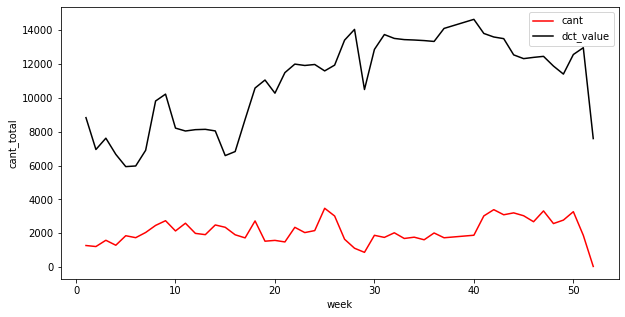

In [56]:
graphic_time(-200916)

# Aca vamos a correr info test

In [57]:
query = """
select distinct
    site.identifier_value as region_code,
    --cp.category,
    --competitor.competitor_name,
    --comp_type.source_code as type,
    --quot_date.full_date as quotation_date,
    EXTRACT(WEEK FROM created_at.full_date) as week,
    su.card_id,
    --su.description,
    --source_type.source_code as source,
    --cp.median_price,
    --cp.number_product_day_quotes,
    --cp.outlier,
    --ot.description as outlier_type,
    --cp.coutn_prices,
    AVG(cp.price)
    --cp.purchase_last_price,
    --cp.stdev_price
from dpr_pricing.snap_daily_collected_prices cp
    left join dpr_shared.dim_site site
        on cp.dim_site = site.site_id
    left join dpr_pricing.dim_competitor competitor
        on cp.dim_competitor = competitor.competitor_id
    left join dpr_pricing.dim_competitor_type comp_type
        on cp.dim_competitor_type = comp_type.competitor_type_id
    left join dpr_pricing.dim_source_type source_type
        on cp.dim_source_type = source_type.source_type_id
    left join dpr_shared.dim_date quot_date
        on cp.dim_quotation_date = quot_date.date_id
    left join dpr_pricing.dim_outlier_type ot
        on cp.dim_outlier_type = ot.outlier_type_id
    left join dpr_shared.dim_date created_at
        on cp.dim_upload_date = created_at.date_id
    left join dpr_shared.dim_stock_unit su
        on cp.dim_stock_unit = su.stock_unit_id
where created_at.full_date::date >= '12-15-2022'
    and comp_type.source_code  = 'main_competitor'
    and site.identifier_value NOT IN ('PBC','GDL')
    and su.product_id != 0
    and su.source_parent_id = 0
    and cp.price > 1
    and cp.outlier = false
GROUP BY 1,2,3--,4
"""

data_ventas_aux_20 = read_connection_data_warehouse.run_read_dwd_query(query)
#data_ventas_aux_2["created_at"] = pd.to_datetime(data_ventas_aux_2["created_at"])

In [58]:
query = """
-- 93058
-- Se toma como base el query 2718
WITH 
ful AS (

SELECT DISTINCT
    bo.order_id,
    bo.submit_date
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_group" bfg        ON bfg.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_order" bfo        ON bfo.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_fulfillment_group" ffg         ON ffg.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order" fo                      ON fo.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_payment" bop            ON bop.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site" s                       ON s.site_id = bo.site_disc
LEFT JOIN  postgres_broadleaf_federate."broadleaf.fb_order_type" fot                ON fot.fb_order_type_id=fo.fb_order_type_id
LEFT JOIN  postgres_broadleaf_federate."broadleaf.blc_order_adjustment" ba          ON ba.order_id = bo.order_id

WHERE fo.fb_order_status_id IN (1,6,7,8)
    AND bo.submit_date::date >= '12-15-2022'
    AND bo.order_status = 'SUBMITTED'
    AND bfo.status NOT IN ('ARCHIVED','CANCELLED')
    AND bop.archived = 'N'
    AND (fot.name IS NULL OR fot.name <> 'REFUND')
    AND bo.customer_id NOT IN {kams} 
    
GROUP BY bo.order_id, bo.submit_date
),

more AS (
SELECT DISTINCT
    s.site_identifier_value AS city,
    bs.addl_product_id AS padre_sku_id,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    AVG(boida.adjustment_value) AS dct_value,
    AVG(boi.sale_price-boida.adjustment_value+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant

FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND (boida.offer_name ILIKE '%hoo%' OR boida.offer_name ILIKE '%investment%' OR boida.offer_name ILIKE '%merma%' OR boida.offer_name ILIKE '%acmk%' OR boida.offer_name ILIKE '%mktpl%')
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3
),

aall AS (

SELECT DISTINCT
    s.site_identifier_value AS city,
    bs2.name,
    bs.addl_product_id AS padre_sku_id,
    bcat2.name AS cat,
    bcat.name AS subcat,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    0 AS dct_value,
    AVG(boi.sale_price-0+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND ((NOT (boida.adjustment_reason ILIKE '%hoo%' OR boida.adjustment_reason ILIKE '%investment%' OR boida.offer_name ILIKE '%merma%' OR boida.adjustment_reason ILIKE '%acmk%' OR boida.adjustment_reason ILIKE '%mktpl%')) or (boida.adjustment_reason is NULL)) 
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3,4,5,6
)

SELECT 

a.city,
a.name,
a.padre_sku_id,
a.cat,
a.subcat,
EXTRACT(WEEK FROM COALESCE(a.submit_date,m.submit_date)) AS week,
COALESCE(AVG(m.final_price),AVG(a.final_price)) AS final_price,
COALESCE(AVG(m.dct_value),0) AS dct_value,
COALESCE(AVG(m.net_final_price),AVG(a.net_final_price)) AS net_final_price,
SUM(COALESCE(a.cant,0)+COALESCE(m.cant,0)) AS cant

FROM aall a
LEFT JOIN more m ON a.city = m.city AND a.submit_date = m.submit_date AND a.padre_sku_id = m.padre_sku_id

GROUP BY 1,2,3,4,5,6
""".format(kams=tuple(clear_buyers[clear_buyers.is_kam == 1].customer_id.unique()))

data_ventas_aux_10 = read_connection_data_warehouse.runQuery(query)
data_ventas_aux_10[["final_price", "dct_value", "net_final_price","cant"]] = data_ventas_aux_10[["final_price", "dct_value", "net_final_price","cant"]].astype(float)
#data_ventas_aux["day"] = pd.to_datetime(data_ventas_aux["day"])
data_ventas_aux_10["dct_perc"] = data_ventas_aux_10.dct_value/data_ventas_aux_10.final_price
data_ventas_aux_10['gmv_usd'] = data_ventas_aux_10.final_price * data_ventas_aux_10.cant

In [59]:
query = """
WITH data AS (
SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_co."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('BAQ','BOG','MDE')

GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_br."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('SPO','BHZ','CWB','VCP')
 
GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_mx."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('CMX','PBC','GDL')
 
GROUP BY 1,2,3
)

SELECT 
    EXTRACT(WEEK FROM (d.close_date - interval '1 day')) AS week,
    p.blc_product_id AS addl_product_id,
    ROUND(SUM(d.stockout_demand),0) AS stockout_demand

FROM data d
INNER JOIN postgres_main_co."purchase_orders.products" p ON d.product_id = p.product_id AND d.region_code = p.region_code
GROUP BY 1,2
"""#.format(tipo_cambio=t_cambio, desde=customer_date_desde, hasta=todays_date, ciudad=city_code)

df_so_10 = read_connection_data_warehouse.run_read_prod_query(query)

In [60]:
df_aux_10 = pd.merge(data_ventas_aux_10, data_ventas_aux_20,  how='left', left_on=['padre_sku_id','week'], right_on = ['card_id','week'])
df_aux_10 = df_aux_10[(df_aux_10.padre_sku_id.isin(active_skus)) & (df_aux_10.padre_sku_id.isin(filter))]

In [61]:
df_aux_10["NPI"] = df_aux_10.net_final_price/df_aux_10.avg

In [62]:
# Group by sku and calculate the mean of the price column
mean_price = df_aux_10.groupby('padre_sku_id')['NPI'].mean()

# Replace missing values in the price columnx with the mean value for each group
df_aux_10['NPI'].fillna(df_aux_10['padre_sku_id'].map(mean_price), inplace=True)

df_aux_10 = df_aux_10.fillna(1)

In [63]:
df_aux_20 = pd.merge(df_aux_10, df_so_10,  how='left', left_on=['padre_sku_id','week'], right_on = ['addl_product_id','week'])
df_aux_20 = df_aux_20.fillna(0)

#----- Fill the stockouts demand
df_aux_20['cant_total'] = df_aux_20.cant + df_aux_20.stockout_demand

#----- Add percentage changes
df_aux_10 = df_aux_20.copy()

In [64]:
letter_to_number = {52: 0, 51: -1, 50: -2, 1:1, 2:2, 3:3, 4:4, 5:5}
df_aux_10['week'] = df_aux_10['week'].map(letter_to_number)

In [65]:
df_aux_10 = df_aux_10.sort_values(['padre_sku_id','week'])

In [66]:
df_aux_10['percentage_change_cant'] = df_aux_10.groupby('padre_sku_id')['cant_total'].pct_change()
df_aux_10['percentage_change_NPI'] = df_aux_10.groupby('padre_sku_id')['NPI'].pct_change()

df_aux_10 = df_aux_10[df_aux_10.week.isin([1,2,3,4,5])].copy()

# Aca genero el modelo

In [67]:
df = df_aux[['city', 'week', 'cat', 'subcat', 'padre_sku_id', 'name', 'final_price', 'net_final_price', 'NPI', 'cant_total', 'percentage_change_cant', 'percentage_change_NPI']].copy()
df.columns = ['city', 'week', 'category', 'subcategory', 'padre_sku_id', 'product', 'final_price', 'net_final_price', 'net_price_index', 'quantity', 'percentage_change_cant', 'percentage_change_NPI']

In [68]:
df['product'] = [x[0] + "_" + x[5] for x in df.values]
df = df.fillna(0)

In [69]:
df['percentage_change_cant_2'] = df.quantity.rolling(window=4).mean()
#df['percentage_change_NPI_2'] = df.percentage_change_NPI.rolling(window=2).mean()

In [70]:
df.category.unique()

array(['Frutas e Verduras', 'Abarrotes', 'Frutas & Verduras',
       'Aseo e Higiene', 'Lácteos & Huevos', 'Desechables', 'Congelados',
       'Carne, Pollo & Pescados', 'Mercearia', 'Laticínios e Ovos',
       'Bebidas', 'Limpeza e Higiene', 'Carnes, Aves e Peixes',
       'Descartáveis', 'Despensa'], dtype=object)

BAQ_Aceite Naoli x 20Lt


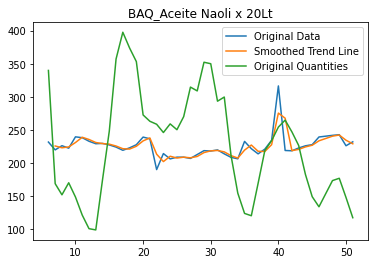

BAQ_Aceite Naoli x 3Lt


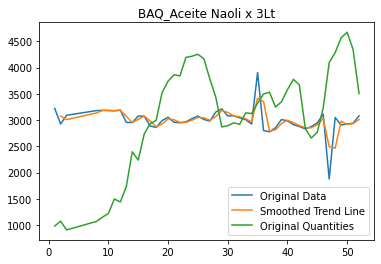

In [71]:
# Import the pandas and statsmodels libraries
import pandas as pd
import statsmodels.api as sm

#create the df
#df = df_aux[['city', 'week', 'cat', 'subcat', 'padre_sku_id', 'name', 'final_price', 'net_final_price', 'NPI', 'cant_total', 'percentage_change_cant', 'percentage_change_NPI']].copy()
#df.columns = ['city', 'week', 'category', 'subcategory', 'padre_sku_id', 'product', 'final_price', 'net_final_price', 'net_price_index', 'quantity', 'percentage_change_cant', 'percentage_change_NPI']

# Group the dataframe by product
grouped = df[(df.week >=0) & (df.category != 'Frutas & Verduras')].groupby('product')

# Initialize an empty list to store the results
results = []

# Loop through each group (i.e., each product)
for product, group in grouped:
    # Fit an OLS model to the data for the current product
    #model = sm.OLS(group['quantity'], group['net_price_index']).fit()
    model = sm.OLS(group['percentage_change_cant_2'], group['net_price_index']).fit()
    # Check if the product is significant for the model
    if model.pvalues[0] < 0.05:
        # If the product is significant, add the results to the list
        results.append({
            'city': group['city'].unique()[0],
            'category': group['category'].unique()[0],
            'subcategory': group['subcategory'].unique()[0],
            'padre_sku_id': group['padre_sku_id'].unique()[0],
            'product': product,
            'week': group['week'].values,
            'net_price_index': group['net_price_index'].values,
            'model': model,
            't_score': model.pvalues[0],
            'quantity': group['percentage_change_cant_2'].values,
            'predicted_quantity_sold': model.predict(group['net_price_index']).values,
            'moving_average': model.predict(group['net_price_index']).rolling(window=2).mean().values
        })

# Convert the results list to a pandas dataframe
results_df = pd.DataFrame(results)

# Plot the original data and the smoothed trend line for each significant product
import matplotlib.pyplot as plt
i=0
for product, product_df in results_df.groupby('product'):
    print(product)
    plt.plot(product_df['week'][i], product_df['predicted_quantity_sold'][i], label='Original Data')
    plt.plot(product_df['week'][i], product_df['moving_average'][i], label='Smoothed Trend Line')
    plt.plot(product_df['week'][i], product_df['quantity'][i], label='Original Quantities')
    plt.legend()
    plt.title(product)
    plt.show()
    i+=1
    if i == 2:
        break

In [72]:
results_df.padre_sku_id.nunique()

1869

In [73]:
results_df.head()

,city,category,subcategory,padre_sku_id,product,week,net_price_index,model,t_score,quantity,predicted_quantity_sold,moving_average
0,BAQ,Abarrotes,Aceites & Grasas,180605,BAQ_Aceite Naoli x 20Lt,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[1.0184900680920135, 0.9666789894643272, 0.994...",<statsmodels.regression.linear_model.Regressio...,2.472591e-21,"[339.875, 169.11, 152.3025, 170.4525, 148.9675...","[231.8625475748753, 220.06758848831086, 226.37...","[nan, 225.9650680315931, 223.22188186262605, 2..."
1,BAQ,Abarrotes,Aceites & Grasas,180812,BAQ_Aceite Naoli x 3Lt,"[1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[1.006717535324569, 0.9143964621242636, 0.9658...",<statsmodels.regression.linear_model.Regressio...,5.153288e-23,"[980.5, 1072.5, 906.5525, 1068.05, 1149.047500...","[3221.316430443862, 2925.905474002666, 3090.62...","[nan, 3073.6109522232637, 3008.265675675094, 3..."
2,BAQ,Abarrotes,Aceites & Grasas,262159,BAQ_Aceite Ricaceite x 3000ml,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.9725197980561436, 0.9725197980561436, 0.936...",<statsmodels.regression.linear_model.Regressio...,1.218644e-05,"[71.5, 182.7475, 404.9975, 814.495, 1443.7475,...","[630.2524421224279, 630.2524421224279, 607.153...","[nan, 630.2524421224279, 618.702837679745, 618..."
3,BAQ,Abarrotes,Aceites & Grasas,415136,BAQ_Aceite sólido Naoli x 15kg,"[37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4...","[0.7318437565582372, 0.7318437565582372, 0.731...",<statsmodels.regression.linear_model.Regressio...,2.595387e-02,"[60.5, 23.0, 5.0, 7.0, 5.75, 5.0, 4.0, 2.0, 2....","[8.920733562994354, 8.920733562994354, 8.92073...","[nan, 8.920733562994354, 8.920733562994354, 8...."
4,BAQ,Abarrotes,Arroz,-200533,BAQ_Arroz Diana 25und x 500gr,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7518824354871814, 0.7481741078425309, 0.757...",<statsmodels.regression.linear_model.Regressio...,2.126827e-17,"[447.1725, 431.4825, 491.68249999999995, 691.4...","[571.4309703851271, 568.6126397998202, 575.827...","[nan, 570.0218050924736, 572.2202672991561, 57..."


# Aca empiezo a validar el modelo

In [74]:
df2 = df_aux_10[['city', 'week', 'cat', 'subcat', 'padre_sku_id', 'name', 'final_price', 'net_final_price', 'NPI', 'cant_total', 'gmv_usd', 'percentage_change_cant', 'percentage_change_NPI']].copy()
df2.columns = ['city', 'week', 'category', 'subcategory', 'padre_sku_id', 'product', 'final_price', 'net_final_price', 'net_price_index', 'quantity', 'gmv_usd', 'percentage_change_cant', 'percentage_change_NPI']

In [75]:
df_aux_check2 = pd.merge(df2, results_df[['padre_sku_id','model']],  how='inner', left_on=['padre_sku_id'], right_on = ['padre_sku_id'])

In [76]:
df_aux_check2['beta_0'] = [x[13].params[0] for x in df_aux_check2.values]
df_aux_check2['prediction'] = [x[13].predict(x[8])[0] for x in df_aux_check2.values]
df_aux_check2['cant_difference'] = abs((abs(df_aux_check2.quantity) - abs(df_aux_check2.prediction)) / abs(df_aux_check2.prediction))  

In [77]:
df_aux_check2['check'] = np.where(df_aux_check2.cant_difference <= 0.3, 1, 0)

In [78]:
df_aux_check2.week.unique()

array([1., 2., 3., 4., 5.])

In [79]:
df_aux_check2[df_aux_check2.padre_sku_id == 328533]

,city,week,category,subcategory,padre_sku_id,product,final_price,net_final_price,net_price_index,quantity,gmv_usd,percentage_change_cant,percentage_change_NPI,model,beta_0,prediction,cant_difference,check
6848,VCP,1.0,Frutas e Verduras,Legumes,328533,Berinjela,4.118571,4.118571,1.029643,214.0,881.374286,1.206186,0.150439,<statsmodels.regression.linear_model.Regressio...,165.581261,170.489563,0.255209,1
6849,VCP,2.0,Frutas e Verduras,Legumes,328533,Berinjela,4.346939,4.346939,1.003140,214.0,930.244898,0.000000,-0.025740,<statsmodels.regression.linear_model.Regressio...,165.581261,166.101139,0.288372,1
6850,VCP,3.0,Frutas e Verduras,Legumes,328533,Berinjela,4.500000,4.500000,1.028571,206.0,927.000000,-0.037383,0.025352,<statsmodels.regression.linear_model.Regressio...,165.581261,170.312154,0.209544,1
6851,VCP,4.0,Frutas e Verduras,Legumes,328533,Berinjela,3.500000,2.980000,0.620833,247.0,864.500000,0.199029,-0.396412,<statsmodels.regression.linear_model.Regressio...,165.581261,102.798366,1.402762,0
6852,VCP,5.0,Frutas e Verduras,Legumes,328533,Berinjela,4.545397,4.545397,1.024892,197.0,895.443175,-0.202429,0.650833,<statsmodels.regression.linear_model.Regressio...,165.581261,169.702935,0.160852,1


In [81]:
x = df_aux_check2[df_aux_check2.week.isin([1,2,3,4,5])].groupby(by=['city','padre_sku_id','product','beta_0']).agg({'cant_difference':np.mean,'gmv_usd':np.sum, 'check':np.sum}).reset_index()

In [83]:
x[x.check>3].to_excel("skus_accuracy_OK_con_formula.xlsx")

In [153]:
df_gmv_accuracy = x[x.check>3].groupby('city').agg({'padre_sku_id':lambda x: x.nunique(), 'gmv_usd':np.sum}).reset_index()

In [154]:
df_gmv_accuracy

,city,padre_sku_id,gmv_usd
0,BAQ,4,5.556061e+08
1,BHZ,39,9.657279e+05
2,BOG,22,3.959969e+09
3,CMX,52,2.076617e+07
4,CWB,29,2.574402e+05
5,MDE,5,3.954162e+08
6,SPO,93,7.946289e+06
7,VCP,20,9.144768e+04


In [45]:
#x[x.cant_difference<=0.3].groupby('city').agg({'padre_sku_id':lambda x: x.nunique(), 'gmv_usd':np.sum}).reset_index()

In [106]:
df_gmv_all = data_ventas_aux_10[data_ventas_aux_10.week.isin([1,2,3,4])].groupby('city').agg({'gmv_usd':np.sum})

In [107]:
df_gmv_check = pd.merge(df_gmv_all, df_gmv_accuracy,  how='inner', left_on=['city'], right_on = ['city'])

In [108]:
df_gmv_check["proportion_gmv"] = df_gmv_check.gmv_usd_y / df_gmv_check.gmv_usd_x
df_gmv_check

,city,gmv_usd_x,padre_sku_id,gmv_usd_y,proportion_gmv
0,BAQ,2.822276e+09,4,5.556061e+08,0.196865
1,BHZ,5.347112e+06,39,9.657279e+05,0.180607
2,BOG,1.222914e+10,22,3.959969e+09,0.323814
3,CMX,5.043510e+07,52,2.076647e+07,0.411746
4,CWB,2.395512e+06,29,2.574402e+05,0.107468
5,MDE,3.104562e+09,5,3.954162e+08,0.127366
6,SPO,2.610214e+07,93,7.946289e+06,0.304431
7,VCP,2.345534e+06,20,9.144768e+04,0.038988


In [49]:
df_info_sheet = df_aux_check2[(df_aux_check2.week == 5) & (df_aux_check2.padre_sku_id.isin(x[x.check>3].padre_sku_id.unique())) & df_aux_check2.padre_sku_id.isin([180632,172513,225171,415121,71763,257011,184859,-200532,440936,354711,354712,-200916,226810,183500,434277,183491,183484,183488,78522,204584,118709,127609,48239,48242,48245,444759,252809,26182,334960,334959,157414,440828,157411,184309,217167,217166,217168,432093,423719,117810,415124,415721,297166,251665,65663,19739,193561,150836,193562,346532,346531,370209,318525,307911,318537,307926,318536,376959,118407,-201164,-201176,143959,402112,101330,298209,155061,236812,419108,312711,236810,219866,219864,71974,445709,136259,104609,130910,272809,372610,217175,372611,217177,217173,428423,136915,438015,442768,180605,180812,259559,262159,250059,223823,-200533,399349,331818,331819,52808,67822,160209,183327,183321,96574,98309,419411,130864,236662,141513,357809,184217,440825,217569,217568,388110,393959,388919,388916,229120,118309,411571,432068,156059,156060,179959,357762,423726,423730,426074,426072,357767,440820,413530,88514,88515,94411,235259,117260,155260,67344,219910,101365,77084,-200953,384229,18024,217577,204422,438074,376713,435714,438274,340509,435733,435727,282263,429315,415143,282275,282279,285127,354628,282287,282563,285134,299100,282610,282581,419420,280450,297969,442158,358966,358967,282773,440921,282771,412018,282777,282743,438273,281461,281463,281468,426468,280608,402449,402450,290264,290265,290271,290269,290861,350512,412011,415714,412014])]

In [50]:
df_skus = pd.read_csv("skus_elasticidades.csv")

In [51]:
df_skus = pd.merge(df_info_sheet, df_skus,  how='inner', left_on=['padre_sku_id'], right_on = ['padre_sku_id'])

In [ ]:
df_skus["competitor_price"] = df_skus.net_final_price / df_skus.net_price_index
df_skus["New_NPI"] = df_skus.pvp_hook / df_skus.competitor_price
df_skus["predict_elasticity"] = [x[13].predict(x[20])[0] for x in df_skus.values]

In [54]:
df_skus.head()

,city,week,category,subcategory,padre_sku_id,product,final_price,net_final_price,net_price_index,quantity,...,percentage_change_NPI,model,prediction,cant_difference,check,nombre,pvp_hook,competitor_price,New_NPI,predict_elasticity
0,BOG,5.0,Abarrotes,Azúcar & Endulzantes,-200916,Azúcar Bulto x 50kg,206846.366858,199225.824487,0.983350,4777.85,...,-0.025024,<statsmodels.regression.linear_model.Regressio...,2030.713314,1.352794,0,Azúcar Bulto x 50kg,201984,202599.000000,0.996964,2058.827459
1,BOG,5.0,Desechables,Contenedores,48245,Contenedor P1 Wau x 200 und,80691.488562,80691.488562,1.064276,75.00,...,-0.000060,<statsmodels.regression.linear_model.Regressio...,92.897754,0.192661,1,Contenedor P1 Wau x 200 und,81901,75818.181818,1.080229,94.290229
2,BAQ,5.0,Desechables,Contenedores,67344,Contenedor sopa 24 Oz Darnel x 20 und,9851.459815,9851.459815,0.965356,120.00,...,-0.021710,<statsmodels.regression.linear_model.Regressio...,125.047578,0.040365,1,Contenedor sopa 24 Oz Darnel x 20 und,9850,10205.000000,0.965213,125.029048
3,BAQ,5.0,Abarrotes,Azúcar & Endulzantes,67822,Azúcar en Bulto x 50kg,206066.250521,200005.700521,1.009741,462.00,...,0.001714,<statsmodels.regression.linear_model.Regressio...,625.531066,0.261428,1,Azúcar en Bulto x 50kg,199935,198076.153846,1.009385,625.309946
4,BOG,5.0,Lácteos & Huevos,Huevos,104609,Huevos Rojos A x 30 und,15368.229116,14876.289615,0.993224,801.49,...,-0.001331,<statsmodels.regression.linear_model.Regressio...,960.341308,0.165411,1,Huevos Rojos A x 30 und,14636,14977.777778,0.977181,944.829372


In [53]:
#df_skus.to_excel("elasticity_modelS.xlsx", index=False)